In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Column, Integer, String, Float
from sqlalchemy.types import Date
from pprint import pprint
from sqlalchemy.ext.declarative import declarative_base

# Reflect Tables into SQLAlchemy ORM

In [2]:
# engine, connection, session
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
session = Session(bind=engine)
inspector = inspect(engine)

In [3]:
# reflect an existing database into a new model

# reflect the tables
table_names = inspector.get_table_names()
table_names

['measurement', 'station']

In [4]:
# Save references to each table
for table_name in table_names:
    print(f"TABLE: {table_name}")
    columns = inspector.get_columns(table_name)
    pprint(columns)
    sample = engine.execute(f"SELECT * FROM {table_name} LIMIT 5")
    print(f"SAMPLE DATA FROM TABLE {table_name}: ")
    for row in sample:
        print(row)

TABLE: measurement
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  'primary_key': 1,
  'type': INTEGER()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'station',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'date',
  'nullable': True,
  'primary_key': 0,
  'type': TEXT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'prcp',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()},
 {'autoincrement': 'auto',
  'default': None,
  'name': 'tobs',
  'nullable': True,
  'primary_key': 0,
  'type': FLOAT()}]
SAMPLE DATA FROM TABLE measurement: 
(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
TABLE: station
[{'autoincrement': 'auto',
  'default': None,
  'name': 'id',
  'nullable': False,
  

In [5]:
Base = declarative_base()

class Measurement(Base):
    __tablename__ = "measurement"
    id = Column(Integer, primary_key=True)
    station_id = Column("station", String(30))
    date = Column(Date)
    rain = Column("prcp", Float)
    tobs = Column("tobs", Float)


class Station(Base):
    __tablename__ = "station"
    id = Column(Integer, primary_key=True)
    station_id = Column("station", String(30))
    station_name = Column("name", String(100))
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)

In [6]:
# Create our session (link) from Python to the DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
session = Session(bind=engine)

# Exploratory Climate Analysis

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find Start and End dates

min_date, max_date = session.query(
    func.min(Measurement.date), func.max(Measurement.date)
).first()
print(f"start date: {min_date} | end date: {max_date}")

start date: 2010-01-01 | end date: 2017-08-23


In [8]:
# Calculate the date 1 year ago from the last data point in the database
one_year = dt.timedelta(days=365)
start_date = max_date - one_year
stop_date = max_date
print(f"1 year ago from the last data point in the database\nstart date: {start_date} | end date: {stop_date}")

1 year ago from the last data point in the database
start date: 2016-08-23 | end date: 2017-08-23


In [9]:
# Perform a query to retrieve the data and precipitation scores
data_prec_query = (
    session.query(Measurement.date, func.avg(Measurement.rain))
    .filter(Measurement.date >= start_date)
    .filter(Measurement.date <= stop_date)
    .group_by(Measurement.date)
)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prec_df = (
    pd.read_sql(data_prec_query.statement, data_prec_query.session.bind, index_col="date")
    .rename(columns={"avg_1":"precipitation"})
    .sort_index()
)
prec_df


,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


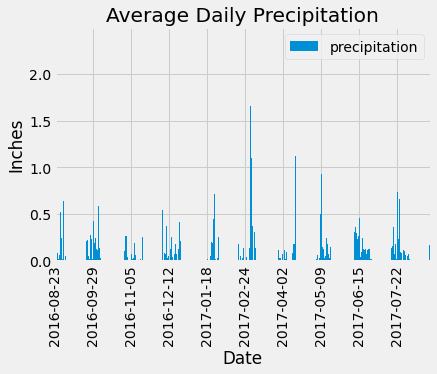

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(
    kind="bar",
    title="Average Daily Precipitation",
)
plt.locator_params(axis="x", nbins=10)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = len(session.query(Measurement.station_id).distinct().all())
print(f"Number of weather station available in Measurement Table: {num_stations}")

num_stations = len(session.query(Station.station_id).distinct().all())
print(f"Number of weather station available in Station table: {num_stations}")

Number of weather station available in Measurement Table: 9
Number of weather station available in Station table: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (
    session.query(Measurement.station_id, func.count(Measurement.id))
    .group_by(Measurement.station_id)
    .order_by(func.count(Measurement.id).desc())
)
for row in active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
data=session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station_id == 'USC00519281').all()
data


[(85.0, 54.0, 71.66378066378067)]

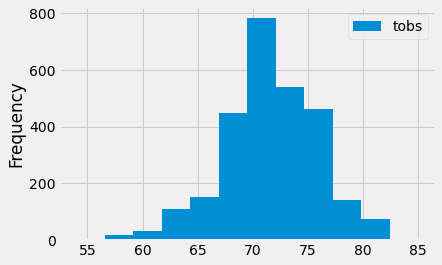

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query((Measurement.tobs)).filter(Measurement.station_id == 'USC00519281').filter(Measurement.date >= min_date).all()

temp_data=pd.DataFrame(temp_data)

temp_data.plot.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
